
# Preprocessing - SCT & Scran Normalization
Michael Sterr

2021-09-25 19:42:53      


# Setup

Run following scripts before:
 * 4-X_scMultiome_FVF-Gut_Preprocessing_Doublet-Detection_XXX-XXX_v1

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
# General
import scipy as sci
import numpy as np
import pandas as pd
import logging
import time
import pickle
from itertools import chain

#R
import rpy2
import rpy2.rinterface_lib.callbacks
from rpy2.robjects import pandas2ri
import anndata2ri

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib import cm
import seaborn as sb

# Analysis
import scanpy as sc
import scvelo as scv

In [3]:
# Settings

## Scanpy settings
sc.settings.verbosity = 3
sc.logging.print_versions()

## ScVelo settings
scv.settings.verbosity = 3
scv.logging.print_versions()

## R settings
### Ignore R warning messages
#### Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

### Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         8.4.0
anndata2ri                  1.0.6
anyio                       NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
backports                   NA
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.2
certifi                     2021.10.08
cffi                        1.15.0
chardet                     4.0.0
charset_norm

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI's XMLRPC API is currently disabled due to unmanageable load and will be deprecated in the near future. See https://status.python.org/ for more information.


In [4]:
# Color maps
exec(open("/home/michi/Software/viscm/maps/michi_bk_bl_gn_yl.py").read())

In [5]:
# Plot settings
%matplotlib inline

## Directory
sc.settings.figdir='/home/michi/Projects/scRNA-seq_Fltp-Venus-iPSC_Notebooks/Figures'

## Plotting parameters
rcParams['figure.figsize']=(20,20) #rescale figures
#sc.set_figure_params(scanpy=True, frameon=False, vector_friendly=False, color_map='tab10' ,transparent=True, dpi=150, dpi_save=300)
sc.set_figure_params(scanpy=True, frameon=False, vector_friendly=False ,transparent=True, dpi=150, dpi_save=300)

## Font
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Source Sans 3']

## Grid & Ticks
rcParams['grid.alpha'] = 0
rcParams['xtick.bottom'] = True
rcParams['ytick.left'] = True

## Embed font
plt.rc('pdf', fonttype=42)

## Define new default settings
plt.rcParamsDefault = plt.rcParams

# Load Data

In [6]:
adata_14=sc.read('/home/michi/Projects/scMultiome_NVF_Mouse-Pancreas-Development_E14.5_Notebooks/Files/E14-5_raw_gex_bc_matrix_filtered_markedDoublets.h5ad')
adata_15=sc.read('/home/michi/Projects/scMultiome_NVF_Mouse-Pancreas-Development_E14.5_Notebooks/Files/E15-5_raw_gex_bc_matrix_filtered_markedDoublets.h5ad')

## Concatenate Samples, Filter Genes & Doublets, & Save

In [8]:
# Concatenate
adata=adata_14.concatenate(adata_15).copy()

In [9]:
# Calc umap & trimap for plotting
sc.pp.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.5)

sc.tl.umap(adata)

computing PCA
    with n_comps=50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 50


2022-02-26 02:01:40.014293: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


In [10]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 23571
filtered out 4803 genes that are detected in less than 20 cells
Number of genes after cell filter: 18768


... storing 'sample' as categorical


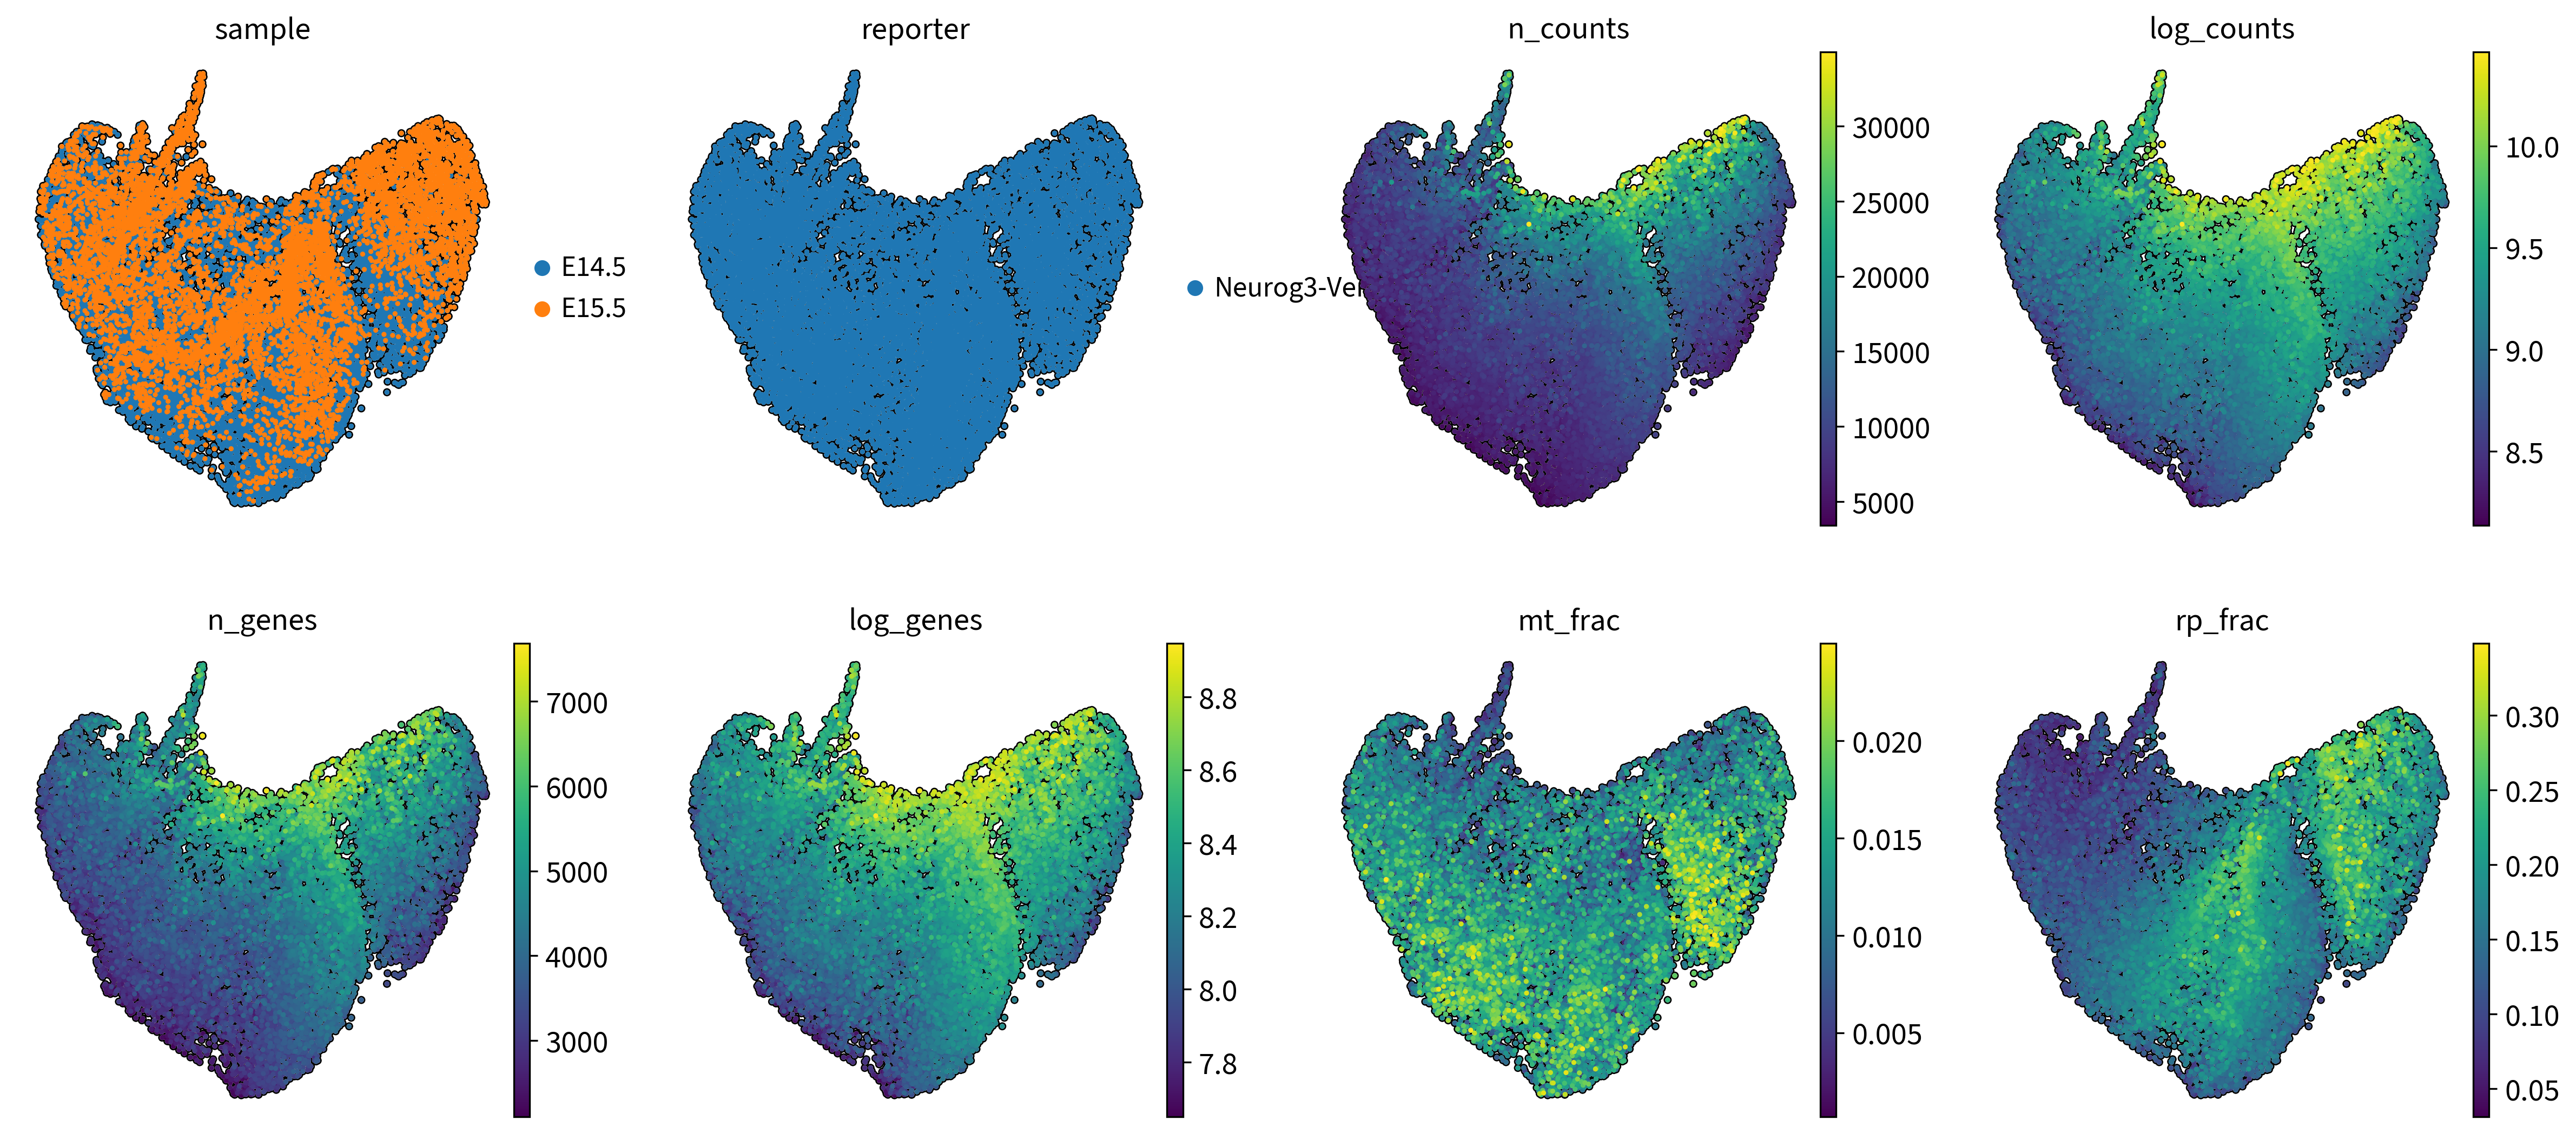

In [11]:
sc.pl.umap(adata, color=['sample','reporter','n_counts','log_counts','n_genes','log_genes','mt_frac','rp_frac'], size=20, add_outline=True, alpha=1, outline_width=(0.3, 0.0), ncols=4)

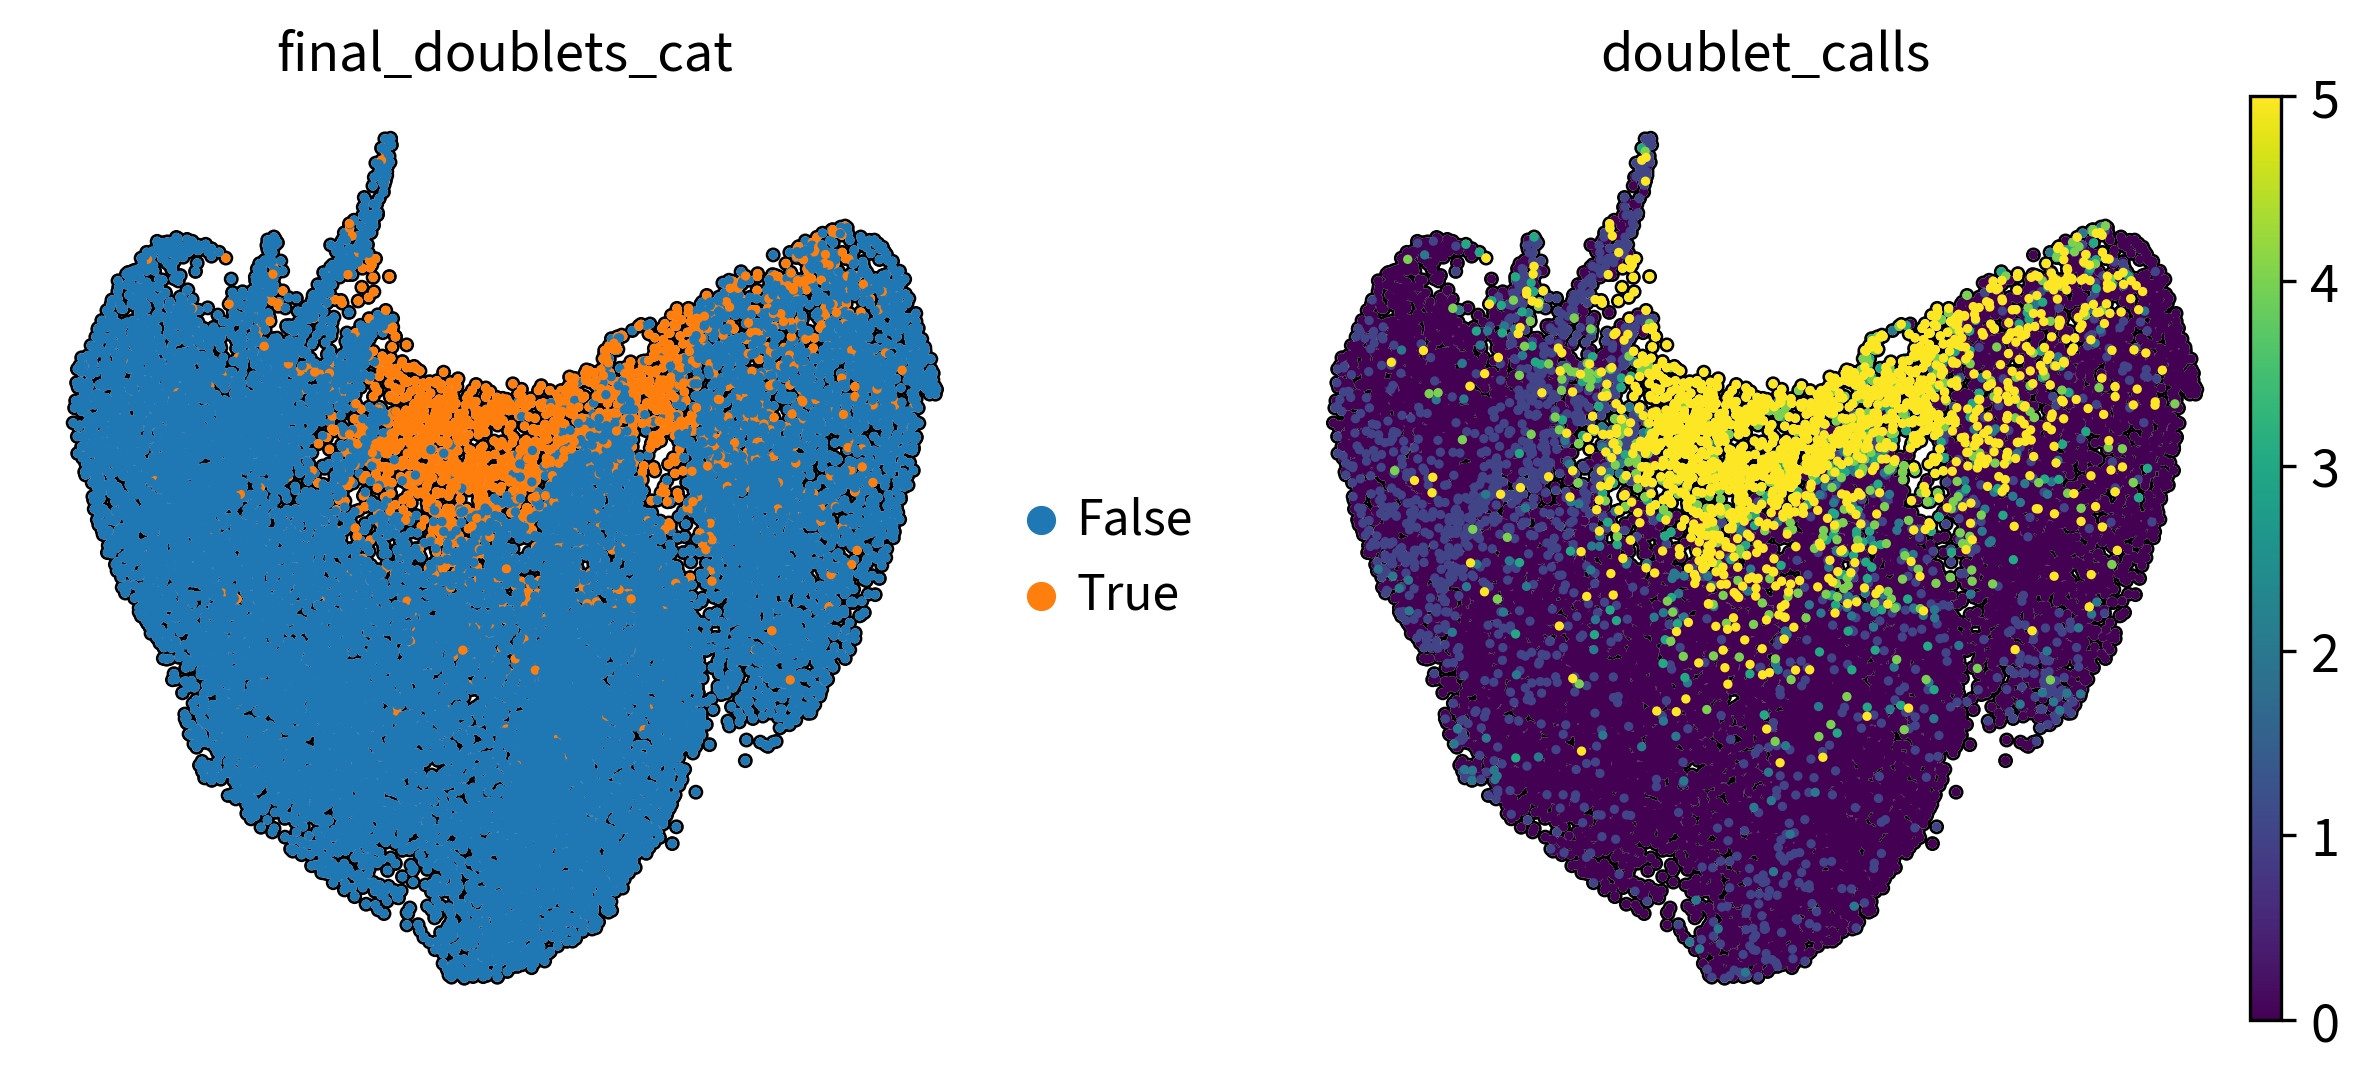

In [12]:
sc.pl.umap(adata, color=['final_doublets_cat','doublet_calls'], size=20, add_outline=True, alpha=1, outline_width=(0.3, 0.0), ncols=2)

In [13]:
# Number of doublet calls calls
print(adata.obs['doublet_calls'].value_counts())

0    15012
1     1508
5     1506
4      354
2      245
3      213
Name: doublet_calls, dtype: int64


In [14]:
# Number of final doublets
print('Number of doublets:')
print(adata.obs['final_doublets'].value_counts())

# Percentage:
print('\nOverall doublet rate: ',adata.obs['final_doublets'].value_counts()[1]/len(adata.obs['final_doublets'])*100,'%')

for sample in set(adata.obs['sample']):
    print('\n',sample,'doublet rate: ',adata.obs['final_doublets'][adata.obs['sample']==sample].value_counts()[1]/len(adata.obs['final_doublets'][adata.obs['sample']==sample])*100,'%')

Number of doublets:
False    16978
True      1860
Name: final_doublets, dtype: int64

Overall doublet rate:  9.873659624163924 %

 E14.5 doublet rate:  10.873891803871901 %

 E15.5 doublet rate:  8.453237410071942 %


In [15]:
# Annotate the data sets
print(adata.obs['sample'].value_counts())

# Checking the total size of the data set
adata.shape

E14.5    11054
E15.5     7784
Name: sample, dtype: int64


(18838, 18768)

In [16]:
# Save
sc.write('/home/michi/Projects/scMultiome_NVF_Mouse-Pancreas-Development_E14.5_Notebooks/Files/E14-E15_adata_filtered_markedDoublets', adata)

In [17]:
adata = adata[adata.obs['final_doublets'] == False]

In [18]:
# Annotate the data sets
print(adata.obs['sample'].value_counts())

# Checking the total size of the data set
adata.shape

E14.5    9852
E15.5    7126
Name: sample, dtype: int64


(16978, 18768)

In [19]:
# Save
sc.write('/home/michi/Projects/scMultiome_NVF_Mouse-Pancreas-Development_E14.5_Notebooks/Files/E14-E15_adata_filtered_rmDoublets', adata)